# Drought hazard team rainfall percentile output processing

In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice
sys.path.append('/g/data/mn51/users/jb6465/drought-github/percentiles_spi_spei_smi')
import utils

In [2]:
# GWL slicing git hash
import subprocess

def get_submodule_hash(submodule_path):
    result = subprocess.run(['git', '-C', submodule_path, 'rev-parse', 'HEAD'], 
                            capture_output=True, text=True, check=True)
    return result.stdout.strip()

# Example usage
submodule_path = '/g/data/mn51/users/jb6465/drought-github/submodules/gwls'
commit_hash = get_submodule_hash(submodule_path)
print(f"Submodule commit hash: {commit_hash}")

Submodule commit hash: 40fe88fca1eaab8491bb3a5b99167db817b24c65


### BC SWITCH (toggle on / off)

In [11]:
BC_SWITCH = True

### 10-50-90 Percentiles for GWL and change between GWLs

In [17]:
if BC_SWITCH:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*p15*{}".format(input_dir, '.nc'))))

In [18]:
files

['/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL1.5_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL2.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_GWL3.0_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_GWL1.2_ACS-QME-AGCD-1960-2022.nc',
 '/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1

In [26]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f"Computing 10-50-90th percentiles of MME for GWL{str(GWL)}")
    GWL_file_list = [file for file in files if f"GWL{str(GWL)}" in file]
    GWL_ens_list = [file[91:-35] for file in files if f"GWL{str(GWL)}" in file]
    MME_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL_file_list, GWL_ens_list)], dim='MME')
    
    p10_50_90_xr = MME_xr.quantile([0.1,0.5,0.9], dim ='MME')
    p10_50_90_xr.attrs['description'] = f"10th, 50th and 90th percentile of MME for 15th percentile threshold using base period of GWL{str(GWL)}."
    p10_50_90_xr.attrs['comment'] = f"Using data on {input_dir}"
    p10_50_90_xr.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    p10_50_90_xr.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    p10_50_90_xr.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    file_name = f"{output_dir}p15_3month_GWL_{str(GWL)}_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}p15_3month_GWL_{str(GWL)}_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
    p10_50_90_xr.to_netcdf(file_name, mode='w')

    #10-50-90th percentile of percent change 
    if GWL != 1.2:
        print(f"---> Computing MME change 10-50-90th percentiles for GWL{str(GWL)} and GWL1.2")
        GWL12_file_list = [file for file in files if "GWL1.2" in file]
        GWL12_ens_list = [file[91:-35] for file in files if "GWL1.2" in file]
        MME_GWL12_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL12_file_list, GWL12_ens_list)], dim='MME')
            
        MME_change_p10_50_90 = (MME_xr-MME_GWL12_xr).quantile([0.1,0.5,0.9], dim ='MME')
        MME_change_p10_50_90.attrs['description'] = f"Change between GWL{str(GWL)} and GWL1.2 for 10th, 50th and 90th percentile of MME for 15th percentile threshold using base period of GWL{str(GWL)}."
        MME_change_p10_50_90.attrs['comment'] = f"Using data on {input_dir}"
        MME_change_p10_50_90.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        MME_change_p10_50_90.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
        file_name = f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc"
        MME_change_p10_50_90.to_netcdf(file_name, mode='w')

Computing 10-50-90th percentiles of MME for GWL1.2
Computing 10-50-90th percentiles of MME for GWL1.5
---> Computing MME change 10-50-90th percentiles for GWL1.5 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL2.0
---> Computing MME change 10-50-90th percentiles for GWL2.0 and GWL1.2
Computing 10-50-90th percentiles of MME for GWL3.0
---> Computing MME change 10-50-90th percentiles for GWL3.0 and GWL1.2


GWL1.5-GWL1.2


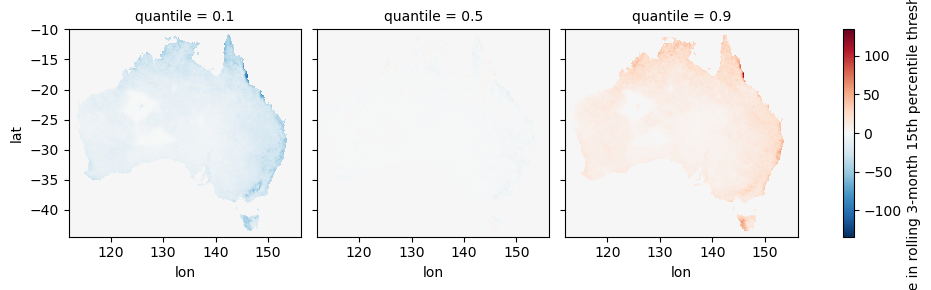

GWL2.0-GWL1.2


<Figure size 640x480 with 0 Axes>

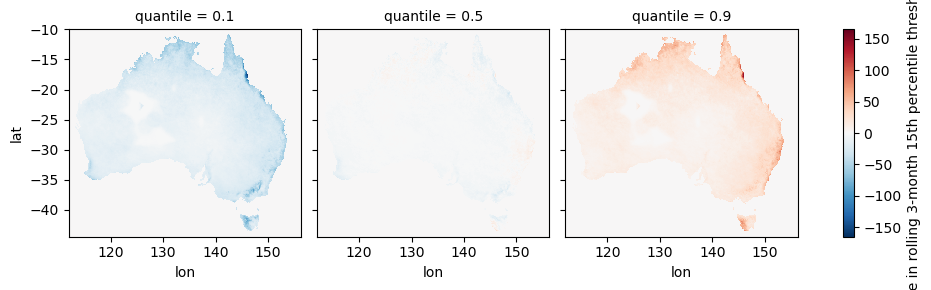

GWL3.0-GWL1.2


<Figure size 640x480 with 0 Axes>

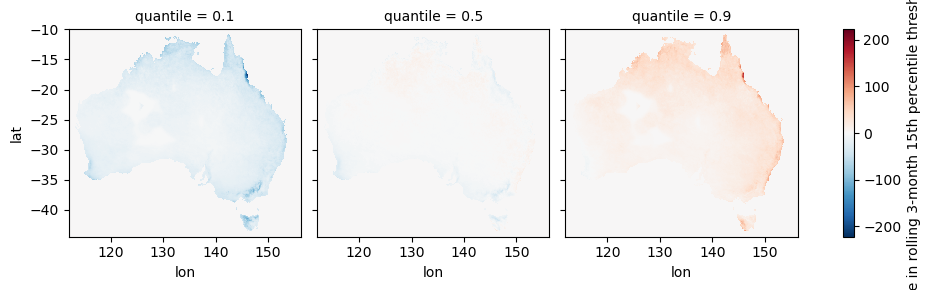

<Figure size 640x480 with 0 Axes>

In [27]:
#quick check of outputs
for GWL in [1.5, 2.0, 3.0]:
    print(f"GWL{str(GWL)}-GWL1.2")
    quick_check_ds = xr.open_dataset(f"{output_dir}p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-QME-AGCD-1960-2022_percentiles_10-50-90.nc")
    (quick_check_ds.p15_3month.mean(dim='month')).plot(col="quantile",cmap="RdBu_r", cbar_kwargs={'label': 'Change in rolling 3-month 15th percentile threshold (mm)'})
    plt.show()
    plt.clf()

### Plotting

In [3]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [4]:
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict

CPU times: user 2min, sys: 1.63 s, total: 2min 2s
Wall time: 2min 5s


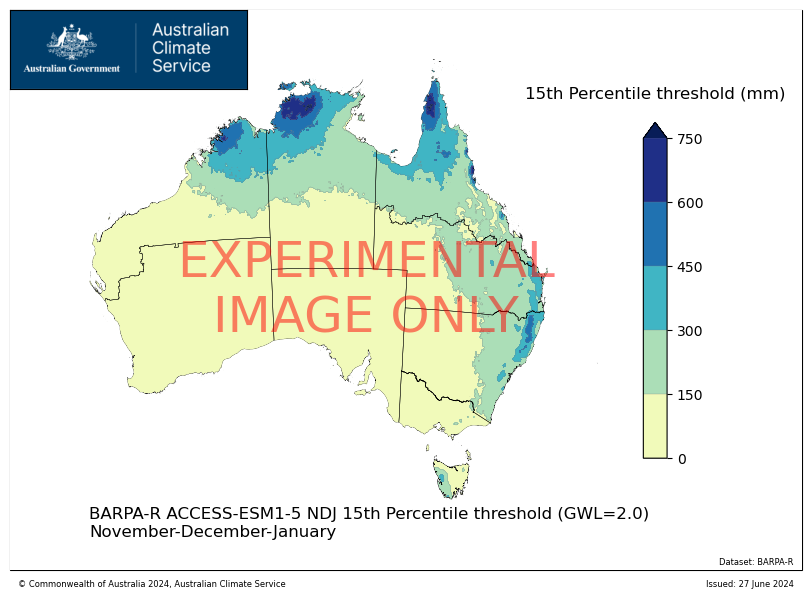

In [5]:
%%time
plot_acs_hazard(data = xr.open_dataset('/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/GWLs/p15_3month_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_GWL2.0.nc').sel(month='DJF').p15_3month,
                    regions = regions_dict['ncra_regions'],
                    cmap = cmap_dict["pr"],
                    ticks = None,
                    cbar_label = "15th Percentile threshold (mm)",
                    cbar_extend = "max",
                    title = "BARPA-R ACCESS-ESM1-5 NDJ 15th Percentile threshold (GWL=2.0)",
                    dataset_name = "BARPA-R",
                    date_range = "November-December-January",
                   );

CPU times: user 57.5 s, sys: 684 ms, total: 58.2 s
Wall time: 59 s


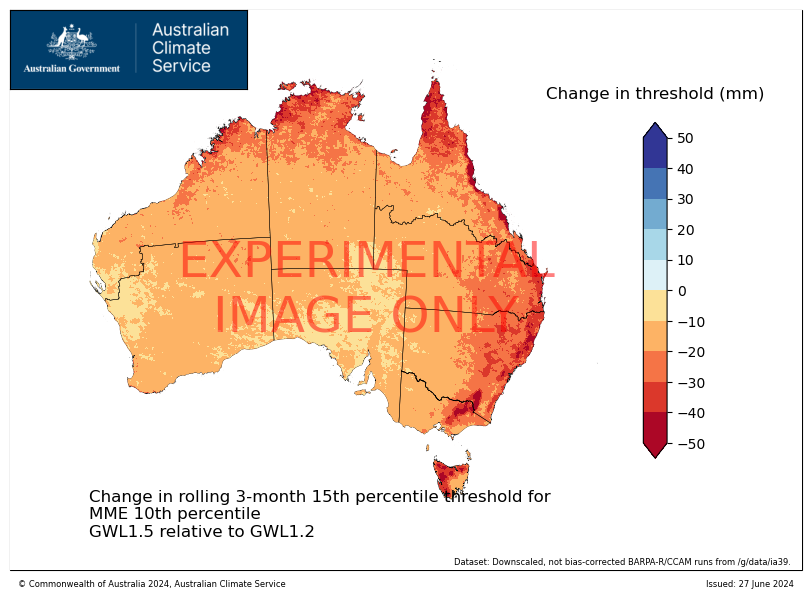

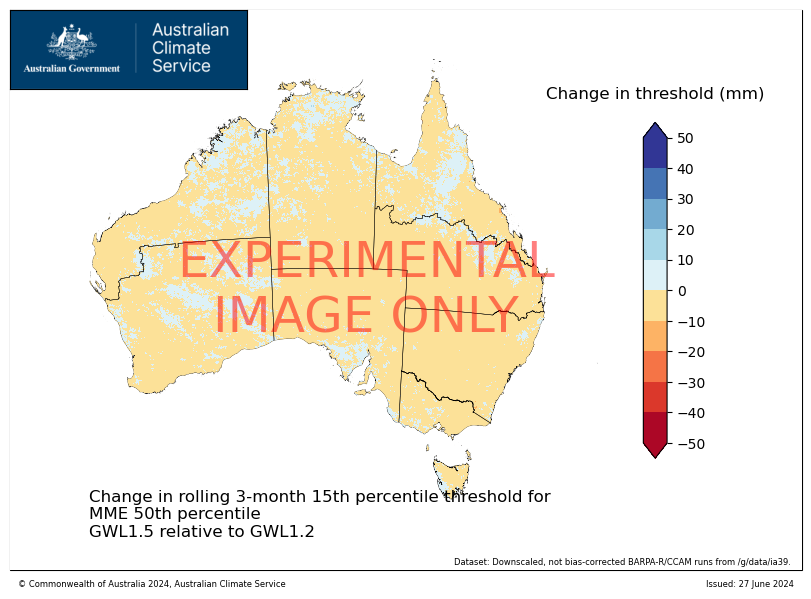

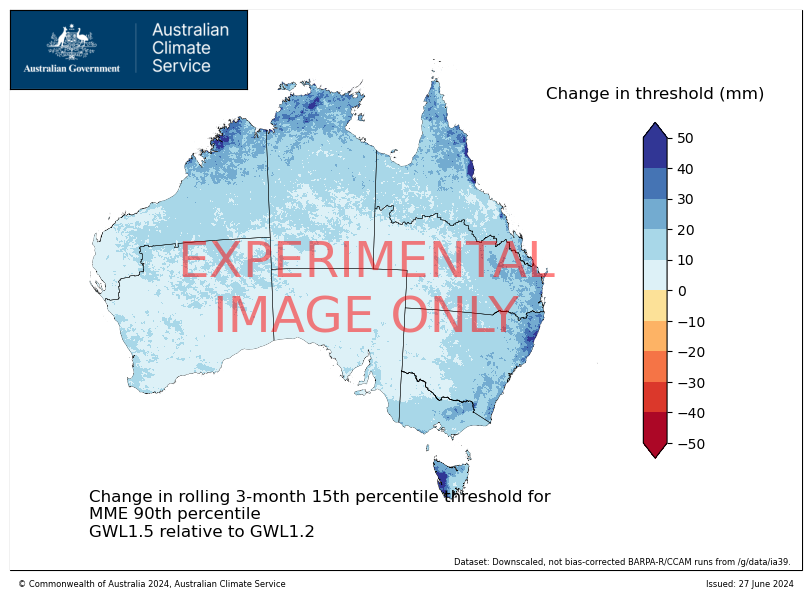

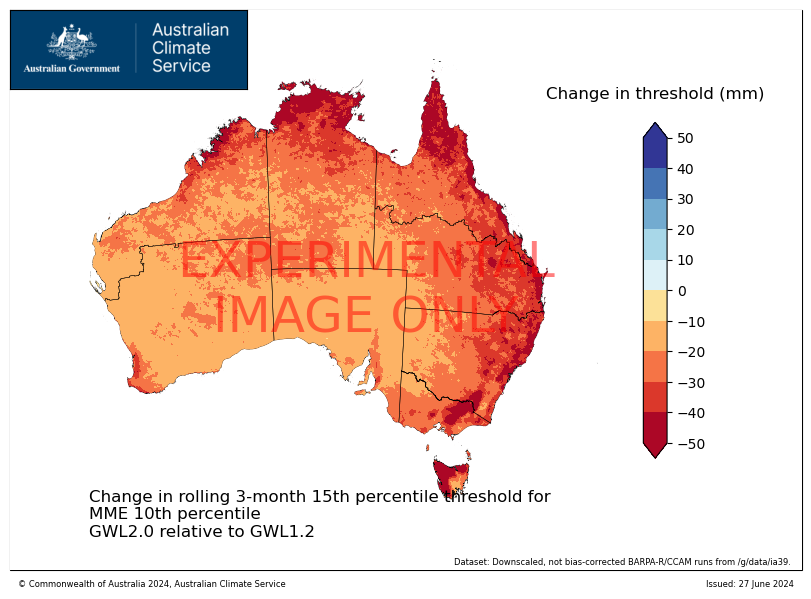

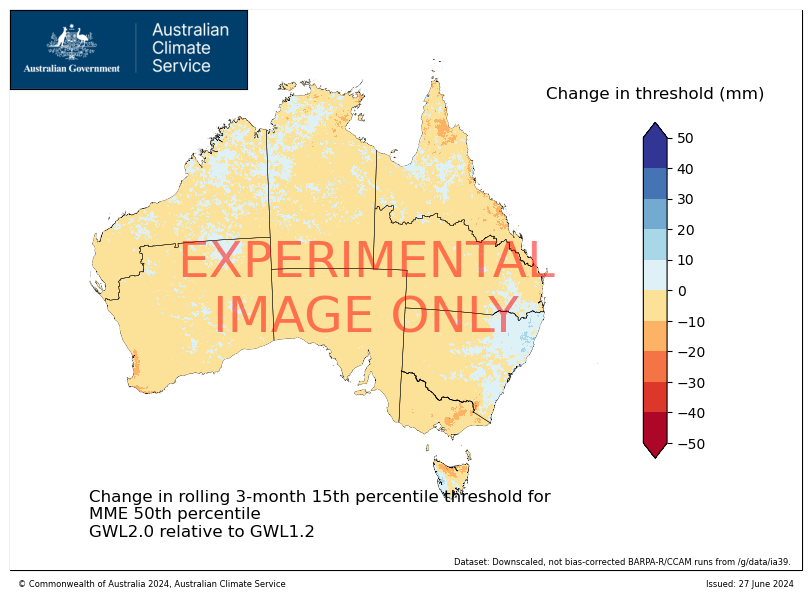

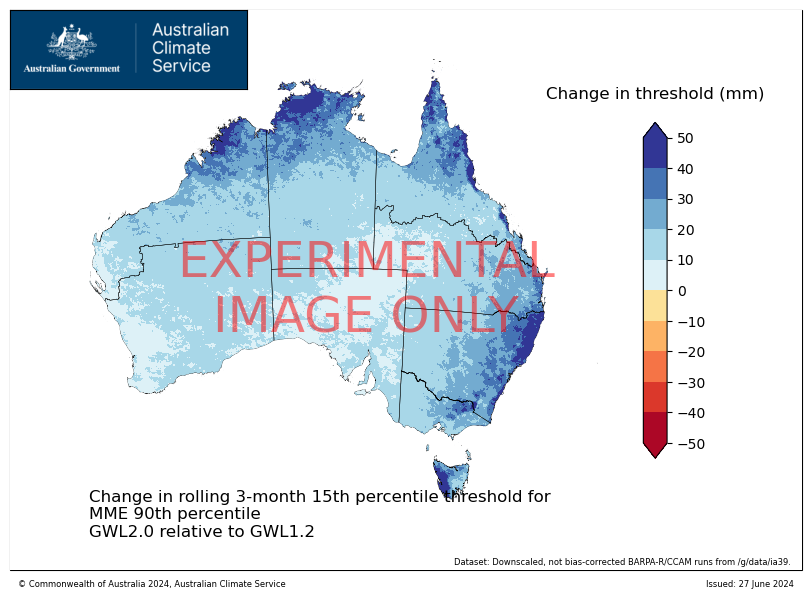

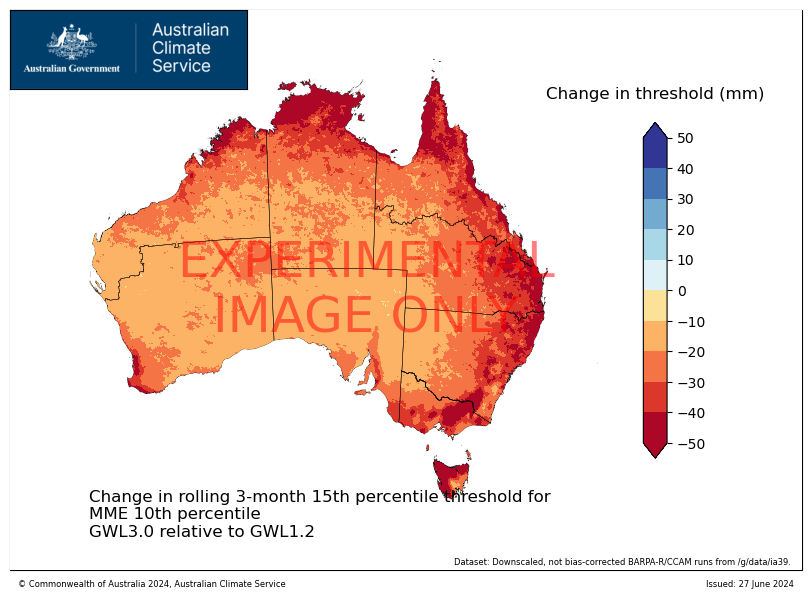

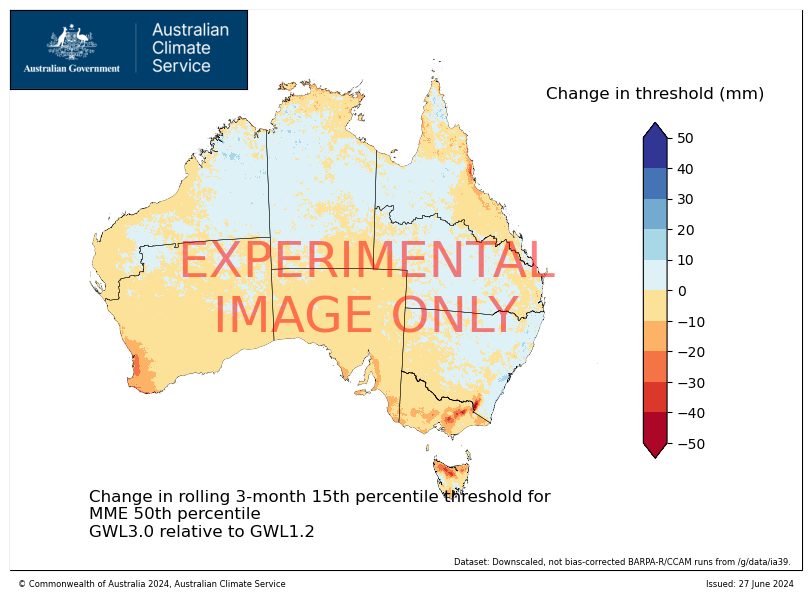

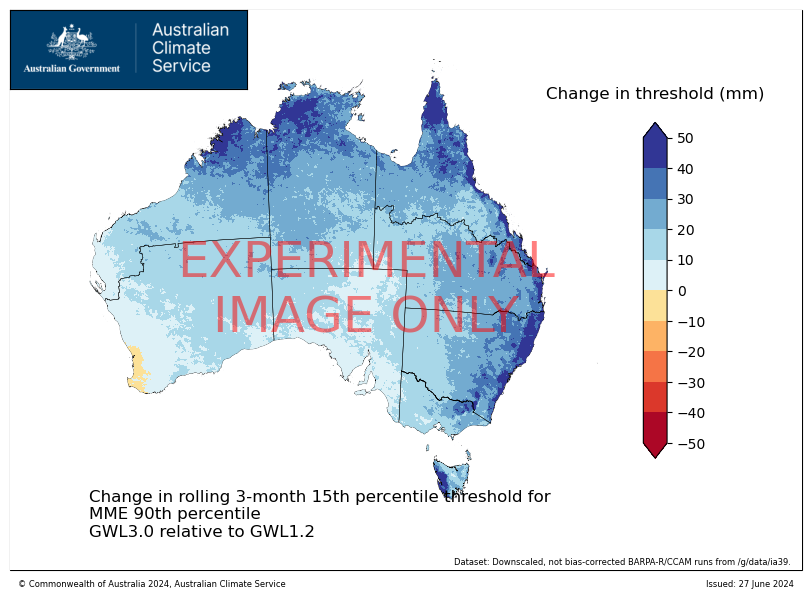

In [7]:
%%time
for GWL in [1.5, 2.0, 3.0]:
    for percentile in [0.1, 0.5, 0.9]:
        plot_file = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_notBC_5km/p15_3month_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc"
        plot_acs_hazard(data = xr.open_dataset(plot_file).sel(quantile=percentile).p15_3month.mean(dim='month'),
        regions = regions_dict['ncra_regions'],
        cmap = cmap_dict["anom_b2r_r"],
        ticks = np.arange(-50, 50.1, 10),
        cbar_label = "Change in threshold (mm)",
        cbar_extend = "both",
        title = f"Change in rolling 3-month 15th percentile threshold for\nMME {str(int(percentile*100))}th percentile",
        dataset_name = "Downscaled, not bias-corrected BARPA-R/CCAM runs from /g/data/ia39. ",
        date_range = f"{plot_file[-40:-34]} relative to GWL1.2",
        contourf = False,
        contour = False
        );


